In [1]:
import osmnx as ox
import networkx
import math
from shapely.geometry import Point, LineString, Polygon
from shapely.affinity import rotate

In [10]:
class SubNode:
    def __init__(self, point_x, point_y, grade=0, id_=None, parent=None):
        self.x = point_x
        self.x = point_y
        self.grade = grade
        self.parent = parent
        self.id = id_
        self.traffic_signals = None  
        
class Node:
    def __init__(self, point_x, point_y, grade=0, osmid=None):
        self.x = point_x
        self.y = point_y
        self.grade = grade
        self.osmid = osmid
        self.type = None
        self.subnodes = []
        

class Lane:
    def __init__(self, line_string, lane_no):

        self.lane_polygon = None
        self.lane_center = line_string
        # this is a line string, which represents straight (and curved) roads
        self.lane_no = None
        self.road = None
        self.speed_limit = None
        self.name = str(self.road.name)+"-lmsp-" + str(self.speed_limit)
        x, y = self.lane_center.coords.xy
        self.start_x = x[0]
        self.start_y = y[0]
        self.end_x = x[-1]
        self.end_y = y[-1]
        self.traffic = []
        
    def insert_car(self, car):
        dist_from_nn = car.get_distance_from_next_node()
        for i, c in enumerate(self.traffic):
            if dist_from_nn > c.get_distance_from_next_node():
                pass
            else:
                self.traffic.insert(i, c)
                break
        

class Road:
    def __init__(self, start_node=None, end_node=None, _type='straight'):
        self.start_node = start_node
        self.end_node = end_node
        self.type = _type
        self.speed_limit = None
        self.heading = None
        self.length = None
        self.no_of_lanes = 2
        self.lanes = []
        # .lanes will contain the lane objects under this road 
        self.lane_width = None
        self.min_bounding_box = None
        self.bounding_polygon = None
        self.name = str(self.start_node.id) + "-" + str(self.end_node.id) + "-msp-" + str(self.speed_limit)


class Map:
    def __init__(self):
        self.__nodes_table= dict()
        self.__roads_table= dict()
        self.__graph = networkx.DiGraph()


In [3]:
address = '567 Stinchcomb Drive, Columbus, Ohio'
distance=300
network_type='drive'

G1 = ox.graph_from_address(address, distance)
# ox.plot_graph(G1)

In [11]:
nodes_table = dict()
roads_table = dict()

for n_start, value in G1.succ.items():
    osmid1 = G1._node[n_start]['osmid']
    x = G1._node[n_start]['x']
    y = G1._node[n_start]['y']
    if not osmid1 in nodes_table.keys():
        nodes_table[osmid1] = ns = Node(point_x=x,point_y=y, osmid=osmid1)
    else:
        ns = nodes_table[osmid1]
        
    for n_end, road in value.items():
        osmid2 = G1._node[n_end]['osmid']
        x = G1._node[n_end]['x']
        y = G1._node[n_end]['y']
        
        if not osmid2 in nodes_table.keys():
            nodes_table[osmid2] = ne = Node(point_x=x,point_y=y, osmid=osmid2)
        else:
            ne = nodes_table[osmid2]
        R = road[0]
        name = R['name'] if 'name' in R.keys() else None
        our_road = create_road(start_node = ns, end_node = ne, name=name, osmid=R['osmid'])
        
        
        
            


In [5]:
from numpy import sign

def get_sub_node_coords(x1, y1, x2, y2):    
        
    os = (x1,y1)
    oe = (x2,y2)
    
    distance = math.sqrt((x1-x2)**2 + (y1-y2)**2)
    slope = math.atan2(y2-y1, x2-x1)
    fs = (0,0)
    fe = (distance, 0)
    
    if abs(slope) <= math.pi/2:
        fs1 = Point(10, 0)
        fs2 = Point(10, -4)

        fe1 = Point(distance-10, 0)
        fe2 = Point(distance-10, -4)
    
    else:
        fs1 = Point(-10, 0)
        fs2 = Point(-10, -4)

        fe1 = Point(-distance+10, 0)
        fe2 = Point(-distance+10, -4)
                
    
    os2 = rotate(fs2, angle=slope, origin=fs, use_radians=True)
    oe2 = rotate(fe2, angle=slope, origin=fs, use_radians=True)
         
        
    return [(x1+ os2.coords[0][0],y1+ os2.coords[0][1]), (x1+ oe2.coords[0][0],y1+ oe2.coords[0][1])]
    
    
    
    

In [8]:
def create_road(start_node, end_node, name, osmid):
    
    x1,y1 = start_node.x, start_node.y
    x2,y2 = end_node.x, end_node.y
    
    [p1, p2] = get_sub_node_coords(x1, y1, x2, y2)
    
    # lane 0: (sn1, sn3)
    # lane 1: (sn2, sn4)
    
    sn1 = SubNode(point_x=p1[0], point_y=p1[1], parent=start_node)
    sn2 = SubNode(point_x=p2[0], point_y=p2[1], parent=start_node)

    
#     ls0 = LineString([p1,p3])
#     ls1 = LineString([p2,p4])
    
#     lane_0 = Lane(line_string=ls0, lane_no=0)
#     lane_1 = Lane(line_string=ls1, lane_no=1)
    
    road = Road(start_node=sn1, end_node=sn2)

#     road.lanes.append(lane_0)
#     road.lanes.append(lane_1)
    
    return road

    
    
    
    
    

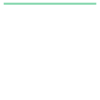

In [180]:
l = LineString([(,0),(1,0)])
l

In [60]:
G1._node[5242033209]

{'osmid': 5242033209, 'x': -83.0312185, 'y': 40.0212356}

229732855 {5242033209: {0: {'length': 46.814877752563419, 'highway': 'residential', 'geometry': <shapely.geometry.linestring.LineString object at 0x7f4c086ce828>, 'osmid': 21405600, 'oneway': False, 'name': 'Harley Drive'}}, 5242033228: {0: {'length': 257.44784362312402, 'highway': 'residential', 'geometry': <shapely.geometry.linestring.LineString object at 0x7f4c086ce7b8>, 'osmid': 21405600, 'oneway': False, 'name': 'Harley Drive'}}, 229732876: {0: {'length': 194.37394018956027, 'highway': 'residential', 'geometry': <shapely.geometry.linestring.LineString object at 0x7f4c086ce748>, 'osmid': 21359082, 'oneway': False, 'name': 'St Johns Court'}}}